In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py   
import os 

# This script was running in Jupyter Notebook
print('Setup complete')

Setup complete


['geometry', 'time', 'vertex_fields', 'viz']
[[-5.0001369]]


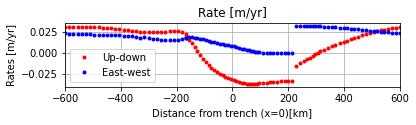

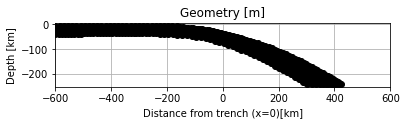

In [174]:
# Import the file from Pylith 
# Make sure that you have correct output folder in a readable correct path
foldername = 'output'
groundsurf = './'+foldername+'/step02_interseismic-groundsurf.h5'
ocean = './'+foldername+'/step02_interseismic-ocean_crust.h5'

with h5py.File(groundsurf, "r") as f:
    with h5py.File(ocean, "r") as oc:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        print(list(f.keys()))    # get first object name/key; may or may NOT be a group
        a_group_key = list(f.keys())[0]

        # Take the vertices from geometry
        vertices = f['geometry/vertices']

        # Take the displacement
        disps = f['/vertex_fields/displacement']

        # Take the cells
        cells = f['/viz/topology/cells']

        # Take the timesteps
        time = f['time']

        # Get the rates and time for one timestep
        timestep = (time[-2]-time[-1])/(3600*24*365.24) # in years
        rates_y = (disps[-2,:,1]-disps[-1,:,1])/timestep # mm/yr
        rates_x = (disps[-2,:,0]-disps[-1,:,0])/timestep

        # Plot the displacement 
        dist = (vertices[:,0])/1e3
        distI = np.argsort(dist); # sorting the x axis order
        sorted_dist = dist[distI]

        plt.subplot(3,1,1) # Plot displacement
        plt.plot(sorted_dist,rates_y.reshape(-1),'.r') # vertical
        plt.plot(sorted_dist,rates_x.reshape(-1),'.b') # east-west

        plt.title('Rate [m/yr]')
        plt.xlabel('Distance from trench (x=0)[km]')
        plt.ylabel('Rates [m/yr]')
        plt.grid()
        plt.xlim(min(sorted_dist),max(sorted_dist))
        plt.legend(['Up-down','East-west'])
        plt.show()

        # plt.subplot(3,1,2) # Plot topography - optional
        # plt.plot(vertices[:,0]/1e3,vertices[:,1],'ko') # vertical
        # plt.title('Topography [m]')
        # plt.xlabel('Distance from trench (x=0)[km]')
        # plt.ylabel('Elevation [m/yr]')
        # plt.grid()


        # Take the vertices from oceanic
        verticesoc = oc['geometry/vertices']
        # Take the cells from oceanic
        cellsoc = oc['/viz/topology/cells']

        plt.subplot(3,1,2) # Plot vertex
        plt.plot(verticesoc[:,0]/1e3,verticesoc[:,1]/1e3,'ko') # vertical

        plt.xlim(min(sorted_dist),max(sorted_dist))
        plt.title('Geometry [m]')
        plt.xlabel('Distance from trench (x=0)[km]')
        plt.ylabel('Depth [km]')
        plt.grid()



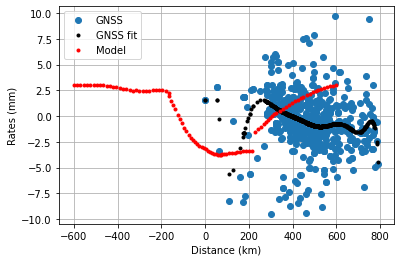

In [175]:
# Read GNSS data
df = pd.read_csv('./GNSS/McCaffrey2013_GNSS.txt',sep='\t')
# print(df)

# Seperate accordingly
lon = df['Longitude']-180
lat = df['Latitude']
Vu = df['Vu']
Vn = df['Vn']
Ve = df['Ve']

# Only select GNSS within boundary box
xmax = 60
xmin = 50
ymax = 50
ymin = 40
velmax = 10 # velocity max (mm/yr)
velmin = -10 # velocity min (mm/yr)

# Get the indices from the boundary conditions
indx = (lon >= xmin) & (lon <= xmax) & (lat >= ymin) & (lat <= ymax) & (Vu <= velmax) & (Vu >= velmin)

lon = lon[indx]
lat = lat[indx]
Vu = Vu[indx]
Ve = Ve[indx]
Vn = Vn[indx]
dist = (lon-min(lon))*111.3 # degrees to km

# Plot GNSS directly from data
plt.plot(dist,Vu,'o')

# Plot a fitting line (GNSS fit)
py = np.poly1d(np.polyfit(dist,Vu,10))
plt.plot(dist,py(dist),'.k')

# Plot Model fitting from Pylith
# m to mm
rates_y_mm = rates_y.reshape(-1)
plt.plot(sorted_dist,rates_y_mm*1e2,'.r')


plt.xlabel('Distance (km)')
plt.ylabel('Rates (mm)')
plt.grid()
plt.legend(['GNSS','GNSS fit','Model'])
